# Importing Libraries and Defining data

In [1]:
import tensorflow as tf
from tensorflow import keras

#Importing tensorflow libs
from keras.preprocessing.image import ImageDataGenerator #image generator label data based on the dir the image in contained in
from keras.optimizers import RMSprop
from keras.optimizers.legacy import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.utils import get_file, image_dataset_from_directory
from keras.models import load_model
#Confusion Matrix Libs
from sklearn.metrics import confusion_matrix
import itertools

#Importing general libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pathlib
import os
import random
import shutil
import time

### Creating folder for Validation images

In [2]:
# Creating Val folder
#os.chdir('datasets/chest_xray/chest_xray/')
#if os.path.isdir('val/NORMAL') is False:
#   os.makedirs('val/NORMAL')
#   os.makedirs('val/PNEUMONIA')

# Moving Images from train folder to val folder
# source = 'chest_xray/train/PNEUMONIA/'
# dest = 'datasets/chest_xray/chest_xray/val/PNEUMONIA'
# files = os.listdir(source)
# np_of_files = len(files) // 25
# for file_name in random.sample(files, np_of_files):
#         shutil.move(os.path.join(source, file_name), dest)

# # Moving Normal Images from train folder to val folder
# source = 'datasets/chest_xray/chest_xray/train/NORMAL/'
# dest = 'datasets/chest_xray/chest_xray/val/NORMAL'
# files = os.listdir(source)
# np_of_files = len(files) // 25
# for file_name in random.sample(files, np_of_files):
#         shutil.move(os.path.join(source, file_name), dest)

### Setting up plotImages

In [3]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(1, 5, figsize=(len(images_arr),len(images_arr)))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% normal")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% pnuemonia")
    plt.show()

### Setting up Confusion Matrix

In [4]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Preprocessing and Augmentation

In [ ]:
tf.random.random_seed(42)
np.random.seed(42)

In [5]:
train_dir = "../datasets/chest_xray/chest_xray/train/"
val_dir = "../datasets/chest_xray/chest_xray/val/"
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [6]:
train_image_generator = ImageDataGenerator(rescale=1/255)
val_image_generator = ImageDataGenerator(rescale=1/255)

train_datagen = train_image_generator.flow_from_directory(
                                                        train_dir,
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='rgb',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        classes=['NORMAL','PNEUMONIA'],
                                                        shuffle= True,
                                                        seed= 42
    )

val_datagen = val_image_generator.flow_from_directory(
                                                        val_dir,
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='rgb',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        classes=['NORMAL','PNEUMONIA'],
                                                        shuffle= False,
                                                        seed= 42
    )

Found 3900 images belonging to 2 classes.
Found 1074 images belonging to 2 classes.


[0. 1. 0. 1. 1.]


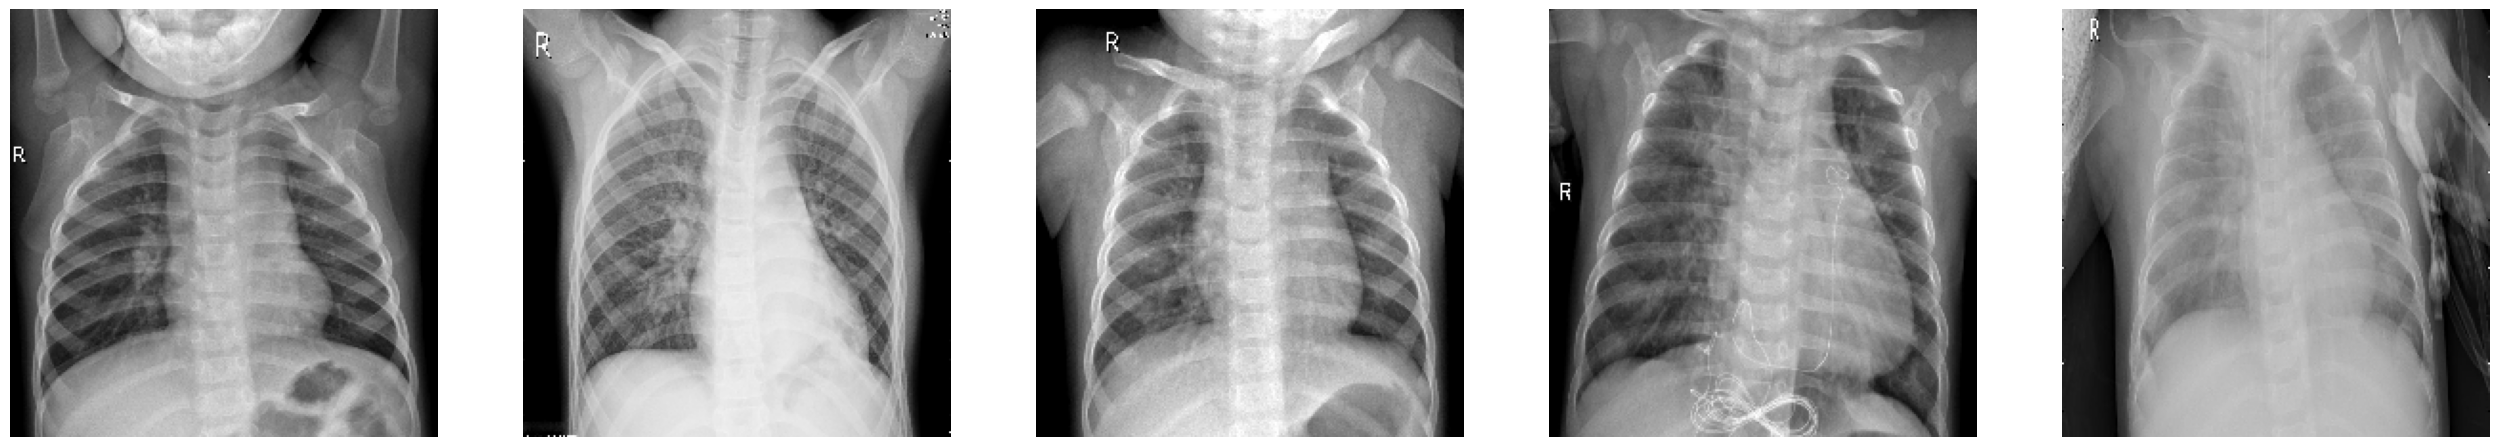

In [7]:
class_names = train_datagen.classes
imgs, class_names = next(train_datagen)
print(class_names[:5])
plotImages(imgs)

In [8]:
train_image_generator = ImageDataGenerator(
    rotation_range= 0.5,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    rescale= 1./255
)

train_datagen = train_image_generator.flow_from_directory(
    train_dir,
    target_size= (IMG_HEIGHT,IMG_WIDTH),
    color_mode='rgb',
    batch_size= batch_size,
    class_mode= 'binary',
    classes=['NORMAL','PNEUMONIA'],
    shuffle= True,
    seed= 42
    )


Found 3900 images belonging to 2 classes.


[0. 1. 0. 1. 1.]


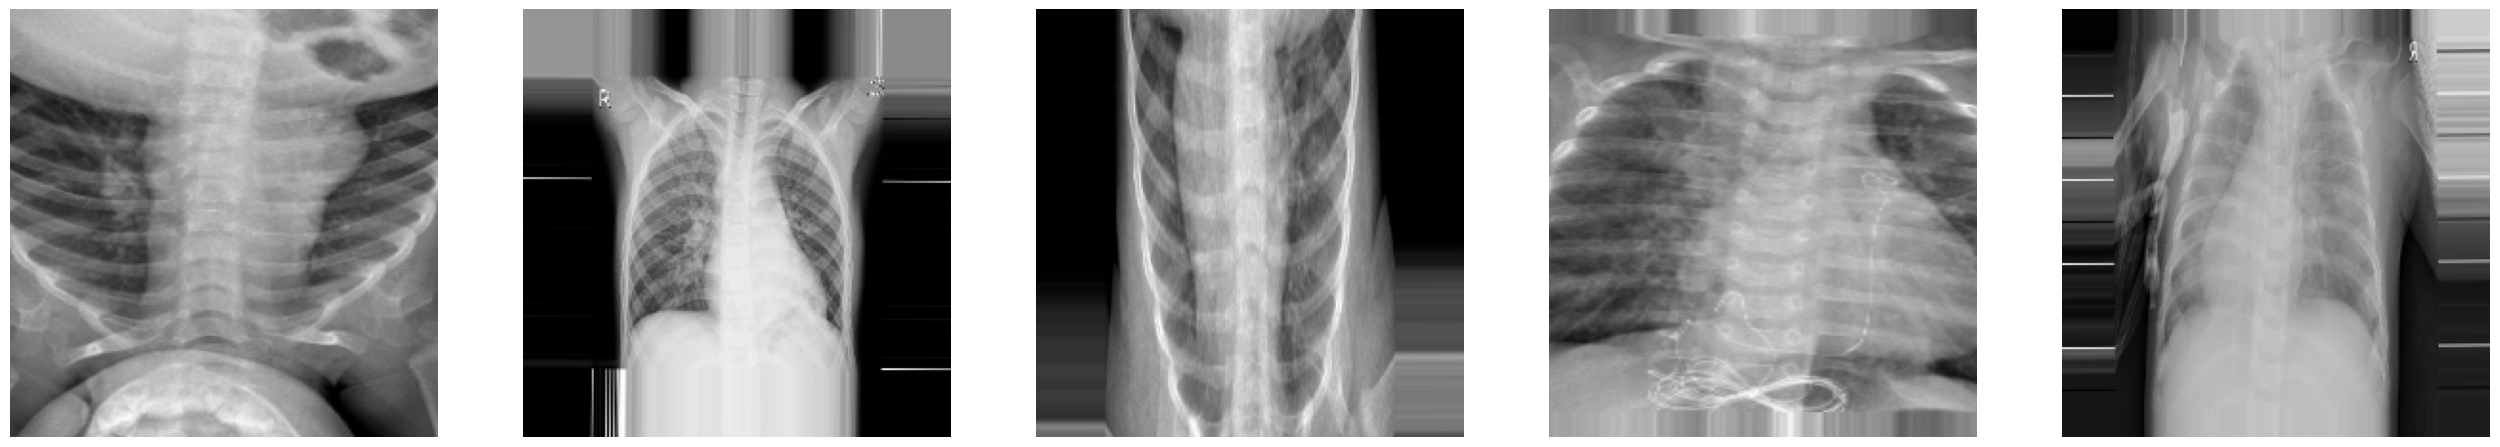

In [9]:
class_names = train_datagen.classes
imgs, class_names = next(train_datagen)
print(class_names[:5])
plotImages(imgs)

# Setting up the CNN

In [10]:
from keras.applications import VGG16, ResNet50V2

base_model = ResNet50V2(
    include_top=False, input_shape=(224, 224, 3), weights="imagenet"
)
base_model.trainable = False
# for layer in base_model.layers[:-4]:
#     layer.trainable = False

2023-11-13 16:18:52.964280: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-13 16:18:52.964310: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-13 16:18:52.964321: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-13 16:18:52.964534: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-13 16:18:52.964555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
def CreateModel():
    model = Sequential()
    model.add(base_model)
    # model.add(Conv2D(filters=32, kernel_size=3, strides=(2, 2)))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.000035),
        metrics=["sparse_categorical_accuracy"],
    )
    return model

# Fitting Model

In [12]:
#del model
model = CreateModel()
latest = tf.train.latest_checkpoint("../Checkpoints")
print(latest)
model.load_weights(latest)
baseline = model.evaluate(val_datagen)[1]

../Checkpoints/0.95


2023-11-13 16:19:01.364633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 41s 839ms/step - loss: 0.1597 - sparse_categorical_accuracy: 0.9479


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 average_pooling2d (Average  (None, 3, 3, 2048)        0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                        

In [15]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callback = EarlyStopping(
    monitor="val_loss", patience=6, restore_best_weights=True, min_delta=0.03, verbose=2
)
reduceLR = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.01,
    patience=2,
    min_lr=0.000035,
    min_delta=0.01,
    verbose=2,
)
checkpoint = ModelCheckpoint(
    filepath=f"../Checkpoints/{{val_sparse_categorical_accuracy:.2f}}",
    save_weights_only=True,
    monitor="val_sparse_categorical_accuracy",
    mode="max",
    save_best_only=True,
    verbose=2,
    initial_value_threshold= baseline
)

In [16]:
%%time
history = model.fit(
    train_datagen,
    steps_per_epoch = train_datagen.n//train_datagen.batch_size,
    epochs = 10,
    validation_data= val_datagen,
    validation_steps= val_datagen.n//val_datagen.batch_size,
    callbacks=[callback, reduceLR, checkpoint],
    verbose = 1
)

Epoch 1/10
121/121 [==============================] - ETA: 0s - loss: 0.1545 - sparse_categorical_accuracy: 0.9416
Epoch 1: val_sparse_categorical_accuracy did not improve from 0.94786
121/121 [==============================] - 102s 743ms/step - loss: 0.1545 - sparse_categorical_accuracy: 0.9416 - val_loss: 0.1756 - val_sparse_categorical_accuracy: 0.9451 - lr: 3.5000e-05
Epoch 2/10
121/121 [==============================] - ETA: 0s - loss: 0.1611 - sparse_categorical_accuracy: 0.9434
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.94786
121/121 [==============================] - 46s 379ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9434 - val_loss: 0.2369 - val_sparse_categorical_accuracy: 0.9252 - lr: 3.5000e-05
Epoch 3/10
121/121 [==============================] - ETA: 0s - loss: 0.1541 - sparse_categorical_accuracy: 0.9439
Epoch 3: val_sparse_categorical_accuracy improved from 0.94786 to 0.95076, saving model to ../Checkpoints/0.95
121/121 [================

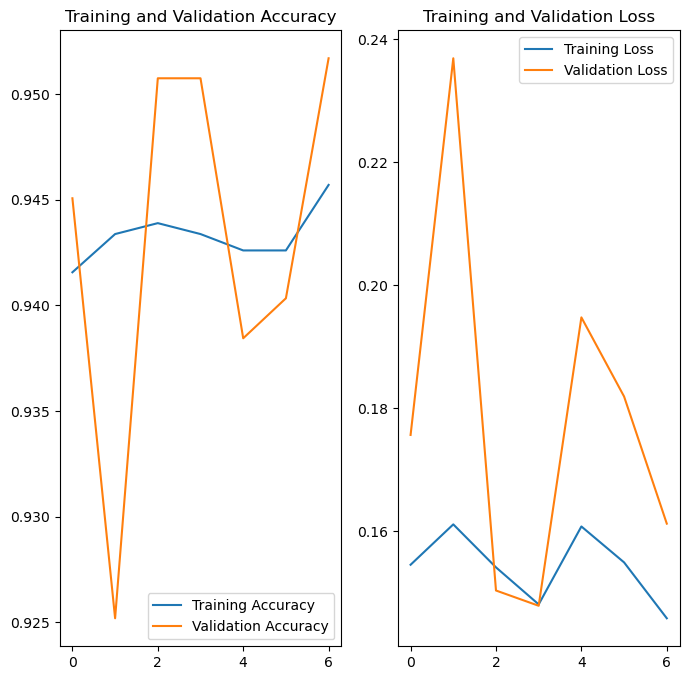

In [19]:
acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(7)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [20]:
model.save('../Models/MedicalClassification_ResNet50V2', overwrite=True)
model.save_weights('../Models/MedicalClassification_ResNet50V2.hdf5', overwrite=True, save_format='h5')

INFO:tensorflow:Assets written to: ../Models/MedicalClassification_ResNet50V2/assets


INFO:tensorflow:Assets written to: ../Models/MedicalClassification_ResNet50V2/assets


### Visualizing training results

# Predicting the Data

In [21]:
test_image_generator = ImageDataGenerator(rescale = 1/255)
test_datagen = test_image_generator.flow_from_directory(
                                                        directory= '../datasets/chest_xray/chest_xray/test/',
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='rgb',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        shuffle= False,
                                                        seed= 42
    )

Found 624 images belonging to 2 classes.


In [22]:
del model
model = CreateModel()
model.load_weights('../Models/MedicalClassification_ResNet50V2.hdf5')

In [23]:
model.evaluate(test_datagen, batch_size = 32)

20/20 [==============================] - 18s 584ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.9103


[0.32493260502815247, 0.9102563858032227]

In [ ]:
img, labels = next(test_datagen)
plotImages(imgs)
print(labels)

### Predicting the Model

In [25]:
predictions = model.predict(
                            x=test_datagen, 
                            batch_size= 128,
                            verbose=1
    )

20/20 [==============================] - 6s 272ms/step


# Visualize testing result

Confusion matrix, without normalization
[[192  42]
 [ 14 376]]


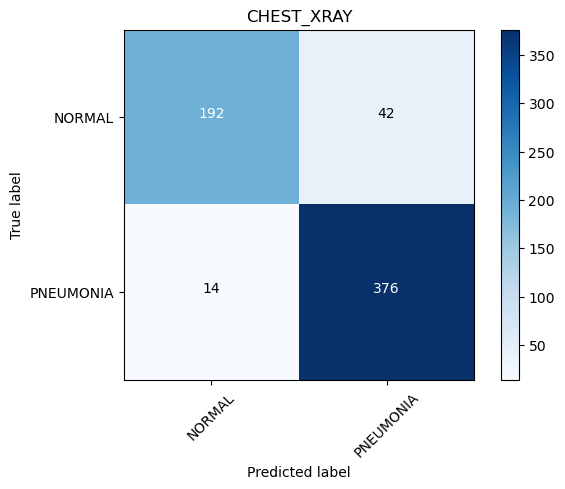

In [26]:
cm = confusion_matrix(y_true=test_datagen.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='CHEST_XRAY')